In [1]:
import os
import sys

# Setting the path for XLuminA modules:
current_path = os.path.abspath(os.path.join('..'))
module_path = os.path.join(current_path)

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from xlumina.__init__ import um, nm, cm, mm, radians
from xlumina.wave_optics import *
import xlumina.vectorized_optics as vectorized_optics
from xlumina.optical_elements import lens, SLM, shake_setup
from xlumina.toolbox import space, image_to_binary_mask, draw_sSLM, wrap_phase
import jax.numpy as jnp
import jax

In [3]:
""" - System characteristics - """
sensor_lateral_size = 1024  # Resolution
wavelength = 632.8*nm
x_total = 1500*um # Space dimension
x, y = space(x_total, sensor_lateral_size)

""" - Define the light source - """
w0 = (1200*um , 1200*um)
gb0 = LightSource(x, y, wavelength)
gb0.gaussian_beam(w0=w0, E0=1)

w1 = (500*um, 500*um)
gb1 = LightSource(x, y, wavelength)
gb1.gaussian_beam(w0=w1, E0=1)

jones_vector = jnp.array([1, 1])
w2 = (1200*um, 1200*um)
gb2 = vectorized_optics.PolarizedLightSource(x, y, wavelength)
gb2.gaussian_beam(w0=w2, jones_vector=jones_vector)

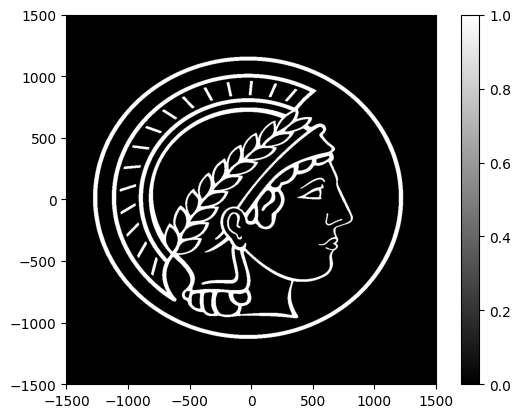

In [4]:
filename = 'MPI_logo.png'
MPI_mask = image_to_binary_mask(filename, x, y, normalize=True, invert=True, threshold=0.5)

# Visualize the mask:
plt.imshow(MPI_mask, cmap = 'gray', extent=[x[0], x[-1], y[0], y[-1]], origin='lower')
plt.colorbar()

In [5]:
key = jax.random.PRNGKey(42)

focal_1 = 10*mm
focal_2 = 20*mm

d1 = 1 # cm
d2 = 4.5 # cm
d3 = 2 # cm

baseline_params = [d1, d2, d3, focal_1, focal_2]

In [6]:
gb2.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Phase')

KeyboardInterrupt: 

In [51]:
def baseline_4f_system(light_source, input_mask, parameters, noise_distance):
    """
    Define an optical table with a 4f system composed by 2 lenses, noise sources in the SLMs and misalignment. 

    [Distances must be input in cm]

    Parameters:
        light_source (LightSource)
        input_mask (jnp.array): Mask to be magnified. 
        parameters (list): Optical parameters [distance_1, distance_2, distance_3, lens_1_focal, lens_2_focal].
        noise_distance (list): random misalignment for [distance_1, distance_2, distance_3]

    Returns the detected light. 
    """


    if light_source.info == 'Wave optics light source':
        light_source.field = input_mask * light_source.field
    elif light_source.info == 'Vectorized light source':
        light_source.Ex = light_source.Ex* input_mask
        light_source.Ey = light_source.Ey* input_mask
        light_source.Ez = light_source.Ez* input_mask
    
    if light_source.info == 'Wave optics light source':

        light_stage0, _ = light_source.RS_propagation(z=parameters[0]*cm + noise_distance[0])
        modulated_lens1, _ = lens(light_stage0, radius=(5/2*mm, 5/2*mm), focal=(parameters[3], parameters[3]))
        light_stage1, _ = modulated_lens1.RS_propagation(z=parameters[1]*cm + noise_distance[1])
        modulated_lens2, _ = lens(light_stage1, radius=(5/2*mm, 5/2*mm), focal=(parameters[4], parameters[4]))
        detected_light, _ = modulated_lens2.RS_propagation(z=parameters[2]*cm + noise_distance[2])

    elif light_source.info == 'Vectorized light source':
        light_stage0, _ = light_source.VRS_propagation(z=parameters[0]*cm + noise_distance[0])
        modulated_lens1, _ = lens(light_stage0, radius=(5/2*mm, 5/2*mm), focal=(parameters[3], parameters[3]))
        light_stage1, _ = modulated_lens1.VRS_propagation(z=parameters[1]*cm + noise_distance[1])
        modulated_lens2, _ = lens(light_stage1, radius=(5/2*mm, 5/2*mm), focal=(parameters[4], parameters[4]))
        detected_light, _ = modulated_lens2.VRS_propagation(z=parameters[2]*cm + noise_distance[2])

    return detected_light

Time taken to perform one RS propagation (in seconds): 0.0140
Time taken to perform one RS propagation (in seconds): 1.1342
Time taken to perform one RS propagation (in seconds): 0.9274


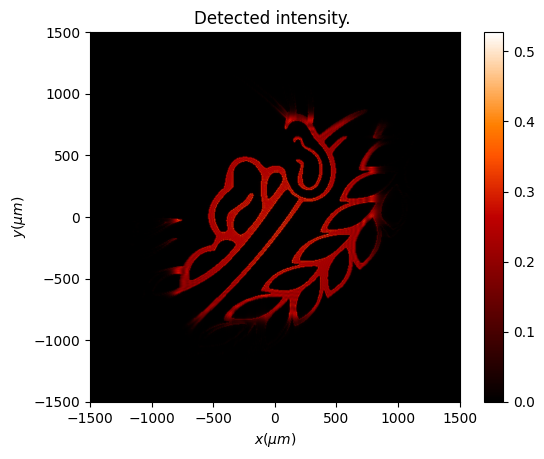

Time taken to perform one RS propagation (in seconds): 0.0035
Time taken to perform one RS propagation (in seconds): 0.9154
Time taken to perform one RS propagation (in seconds): 1.0083


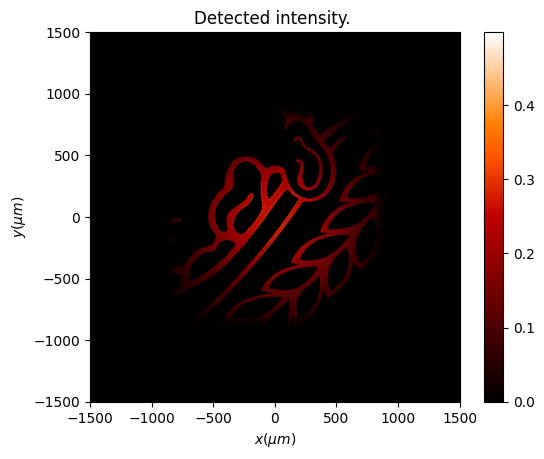

Time taken to perform one VRS propagation (in seconds): 0.0717
Time taken to perform one VRS propagation (in seconds): 0.1469
Time taken to perform one VRS propagation (in seconds): 0.1903


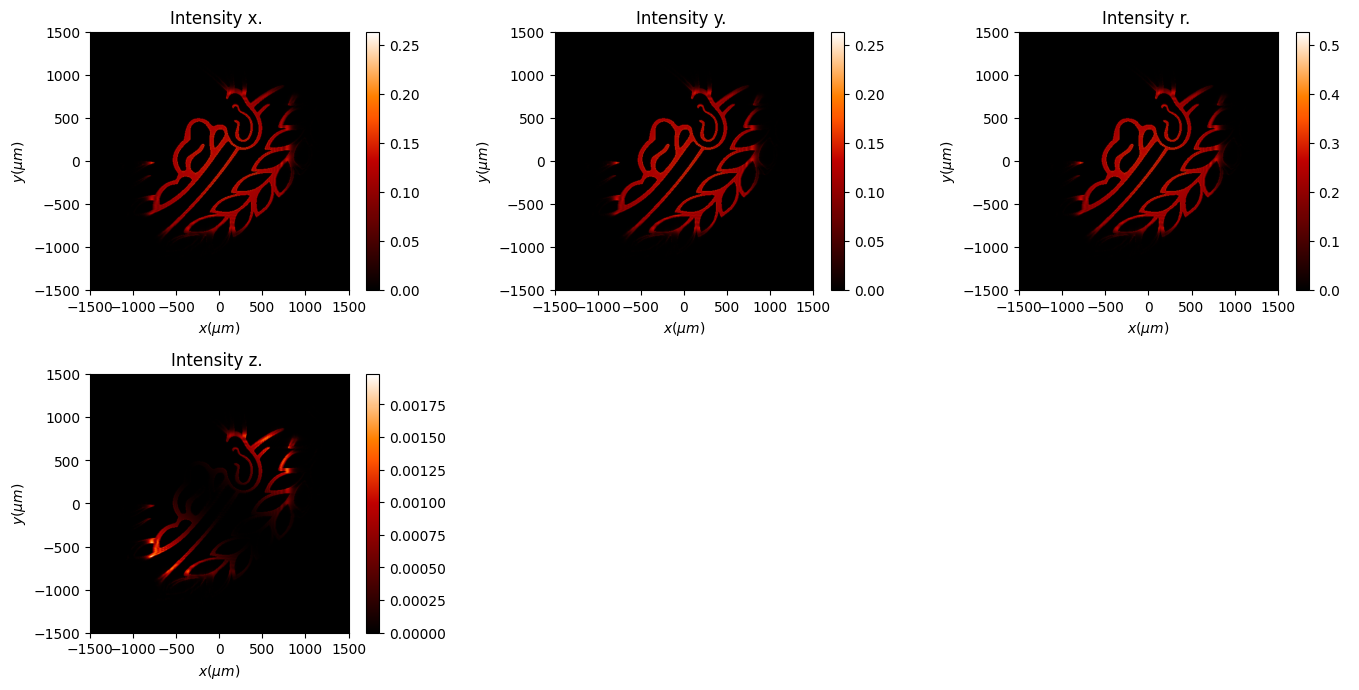

In [52]:
noise_distance = [0.0, 0.0, 0.0]

baseline_light = baseline_4f_system(gb0, MPI_mask, baseline_params, noise_distance)
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

baseline_light = baseline_4f_system(gb1, MPI_mask, baseline_params, noise_distance)
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

baseline_light = baseline_4f_system(gb2, MPI_mask, baseline_params, noise_distance)
baseline_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')